In [17]:
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [18]:
def exponential_smoothing(alpha, s):
    '''
    Primary exponential smoothing
    :param alpha:  Smoothing factor,num
    :param s:      List of data,list
    :return:       List of data after smoothing,list
    '''
    s_temp = [s[0]]
    print(s_temp)
    for i in range(1, len(s), 1):
        s_temp.append(alpha * s[i - 1] + (1 - alpha) * s_temp[i - 1])
    return s_temp

In [19]:
def precess_image(image):
    '''
    Graying and GaussianBlur
    :param image: The image matrix,np.array
    :return: The processed image matrix,np.array
    '''
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  #Grayscale
    gray_image = cv2.GaussianBlur(gray_image, (3, 3), 0)  #Gaussian filtering
    return gray_image

In [20]:
def abs_diff(pre_image, curr_image):
    '''
    Calculate absolute difference between pre_image and curr_image
    :param pre_image:The image in past frame,np.array
    :param curr_image:The image in current frame,np.array
    :return:
    '''
    gray_pre_image = precess_image(pre_image)
    gray_curr_image = precess_image(curr_image)
    diff = cv2.absdiff(gray_pre_image, gray_curr_image)
    res, diff = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #  fixme：Here first write it in the form of a simple sum
    cnt_diff = np.sum(np.sum(diff))
    return cnt_diff

In [21]:
class KeyFrameGetter:
    '''
    Get the key frame
    '''

    def __init__(self, video_path, img_path, window=25):
        '''
        Define the param in model.
        :param video_path: The path points to the movie data,str
        :param img_path: The path we save the image,str
        :param window: The comparing domain which decide how wide the peek serve.
        '''
        self.window = window  # Number of key frames
        self.video_path = video_path  # Video path
        self.img_path = img_path  #Image storage path
        self.diff = []
        self.idx = []
        
    def load_diff_between_frm(self, smooth=True, alpha=0.07):
        '''
        Calculate and get the model param
        :param smooth: Decide if you want to smooth the difference.
        :param alpha: Difference factor
        :return:
        '''
        print("load_diff_between_frm")
        cap = cv2.VideoCapture(self.video_path)  # Open video file
        diff = []
        frm = 0
        pre_image = np.array([])
        curr_image = np.array([])

        while True:
            frm = frm + 1

            # success Indicates whether it is successful, data is the image data of the current frame; 
            #.read reads one frame of image and moves to the next frame
           # cv2.imwrite('./img/' + str(num) + ".jpg", data)
            success, data = cap.read()
            if not success:
                break
            #  # Here is the main body
            #    # Record the data each time
            #  TODO: It can be optimized here, for example, one batch can be entered to speed up the rotation speed
            if frm == 1:
                pre_image = data
                curr_image = data
            else:
                pre_image = curr_image
                curr_image = data
            #  Make difference
            diff.append(abs_diff(pre_image, curr_image))
            #  End Loop

            if frm % 100 == 0:
                print('Detect Frame:', str(frm))
        cap.release()

        if smooth:
            diff = exponential_smoothing(alpha, diff)
        #  Standardized data
        self.diff = np.array(diff)
        mean = np.mean(self.diff)
        dev = np.std(self.diff)
        self.diff = (self.diff - mean) / dev

        #  Standardized data
        self.pick_idx()
        return

    def pick_idx(self):
        '''
        Get the index which accord to the frame we want(peek in the window)
        :return:
        '''
        print("pick_idx")
        for i, d in enumerate(self.diff):
            ub = len(self.diff) - 1
            lb = 0
            if not i - self.window // 2 < lb:
                lb = i - self.window // 2
            if not i + self.window // 2 > ub:
                ub = i + self.window // 2

            comp_window = self.diff[lb:ub]
            if d >= max(comp_window):
                self.idx.append(i)

        tmp = np.array(self.idx)
        tmp = tmp + 1  # to make up the gap when diff
        self.idx = tmp.tolist()
        print("Extract the Frame Index:" + str(self.idx))

    def save_key_frame(self):
        '''
        Save the key frame image
        :return:
        '''
        print("save_key_frame")
        cap = cv2.VideoCapture(self.video_path)  # Open video file
        frm = 0
        idx = set(self.idx)
        while True:
            frm = frm + 1
            success, data = cap.read()
            if not success:
                break
            if frm in idx:
                print('Extracting idx:'+str(frm))
                cv2.imwrite(self.img_path + '/' +str(frm) + ".jpg", data)
                idx.remove(frm)
            if not idx:
                print('Done！')
                break

    def plot_diff_time(self):
        '''
        Plot the distribution of the difference along to the frame increasing.
        :return:
        '''
        plt.plot(self.diff, '-b')
        plt.plot(np.array(self.idx) - 1, [self.diff[i-1] for i in self.idx], 'or')
        plt.xlabel('Frame Pair Index')
        plt.ylabel('Difference')
        plt.legend(['Each Frame', 'Extract Frame'])
        plt.title("The Difference for Each Pair of Frame")
        plt.plot()
        plt.show()

    

s10_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s10_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[32, 46]
[0.2604379653930664]
save_key_frame
Extracting idx:32
Extracting idx:46
Done！


s10_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s10_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[42]
[0.2604379653930664, 0.21824240684509277]
save_key_frame
Extracting idx:42
Done！


s10_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s10_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[47, 62]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867]
save_key_frame
Extracting idx:47
Extracting idx:62
Done！


s10_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s10_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[34]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898]
save_key_frame
Extracting idx:34
Done！


s10_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s10_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[39, 40]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168]
save_key_frame
Extracting idx:39
Extracting idx:40
Done！


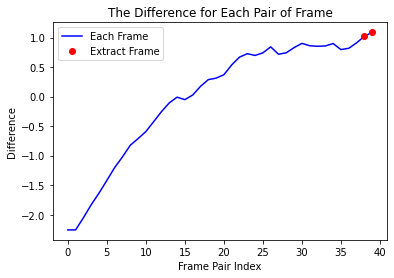

s12_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s12_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[12, 35, 67]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672]
save_key_frame
Extracting idx:12
Extracting idx:35
Extracting idx:67
Done！


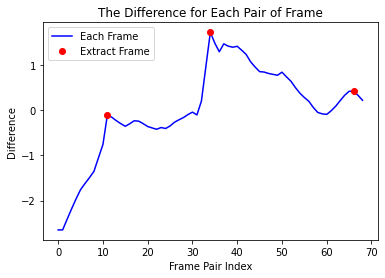

s12_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s12_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[23, 43, 82]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208]
save_key_frame
Extracting idx:23
Extracting idx:43
Extracting idx:82
Done！


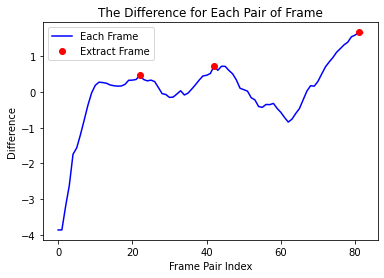

s12_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s12_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[31, 62, 63]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824]
save_key_frame
Extracting idx:31
Extracting idx:62
Extracting idx:63
Done！


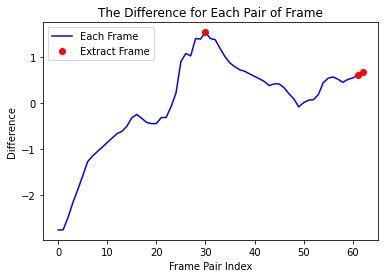

s12_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s12_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[25, 42, 54, 72, 73]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256]
save_key_frame
Extracting idx:25
Extracting idx:42
Extracting idx:54
Extracting idx:72
Extracting idx:73
Done！


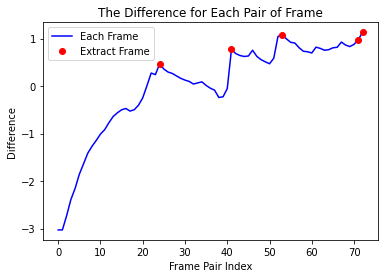

s12_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s12_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[36]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273]
save_key_frame
Extracting idx:36
Done！


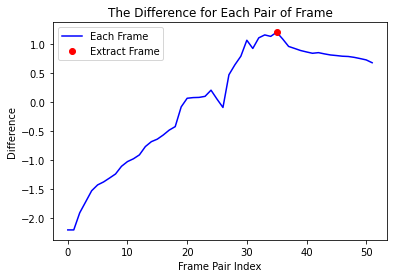

s13_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s13_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[36, 50, 65, 69]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917]
save_key_frame
Extracting idx:36
Extracting idx:50
Extracting idx:65
Extracting idx:69
Done！


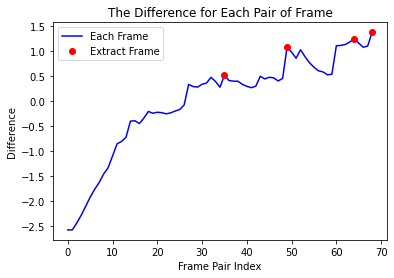

s13_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s13_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[28, 45, 79, 80]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826]
save_key_frame
Extracting idx:28
Extracting idx:45
Extracting idx:79
Extracting idx:80
Done！


s13_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s13_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[27, 70, 71]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668]
save_key_frame
Extracting idx:27
Extracting idx:70
Extracting idx:71
Done！


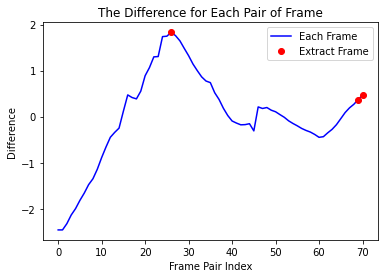

s13_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s13_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[19, 36, 61, 62]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414]
save_key_frame
Extracting idx:19
Extracting idx:36
Extracting idx:61
Extracting idx:62
Done！


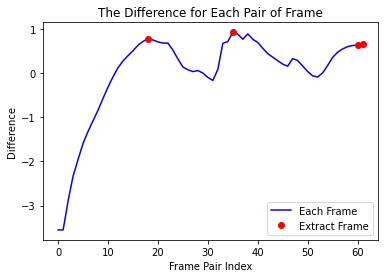

s13_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s13_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[28]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379]
save_key_frame
Extracting idx:28
Done！


s14_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s14_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[27, 53]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516]
save_key_frame
Extracting idx:27
Extracting idx:53
Done！


s14_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s14_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[41]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215]
save_key_frame
Extracting idx:41
Done！


s14_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s14_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[42, 69]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473]
save_key_frame
Extracting idx:42
Extracting idx:69
Done！


s14_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s14_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[38, 57]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418]
save_key_frame
Extracting idx:38
Extracting idx:57
Done！


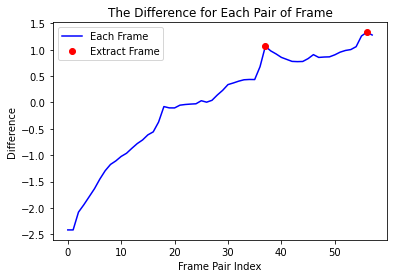

s14_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s14_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[54]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793]
save_key_frame
Extracting idx:54
Done！


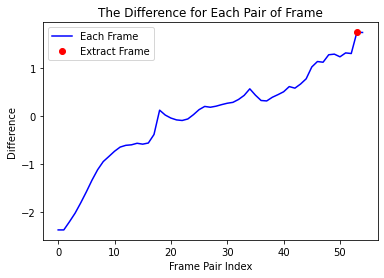

s15_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s15_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[52]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223]
save_key_frame
Extracting idx:52
Done！


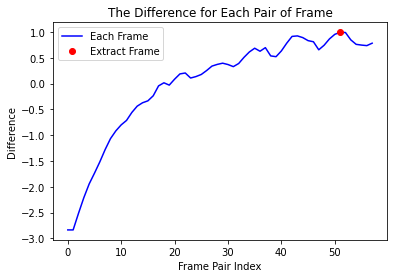

s15_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s15_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[24, 36, 62]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598]
save_key_frame
Extracting idx:24
Extracting idx:36
Extracting idx:62
Done！


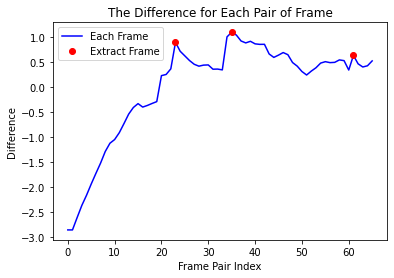

s15_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s15_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[24, 37]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293]
save_key_frame
Extracting idx:24
Extracting idx:37
Done！


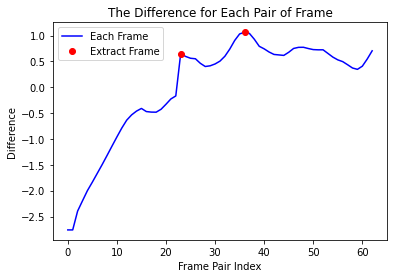

s15_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s15_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[34, 35]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973]
save_key_frame
Extracting idx:34
Extracting idx:35
Done！


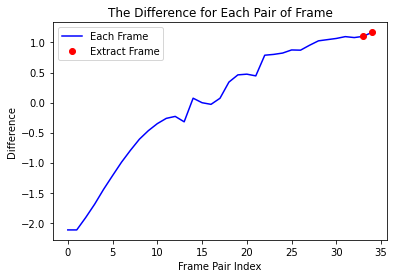

s15_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s15_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[34]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066]
save_key_frame
Extracting idx:34
Done！


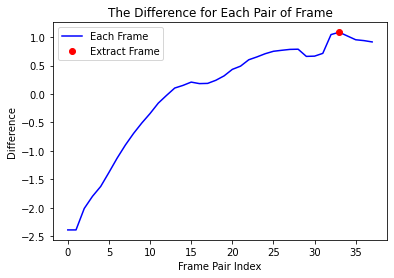

s16_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s16_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[25, 39]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488]
save_key_frame
Extracting idx:25
Extracting idx:39
Done！


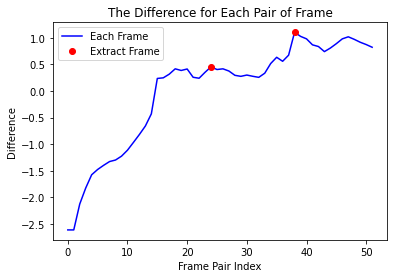

s16_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s16_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[50]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676]
save_key_frame
Extracting idx:50
Done！


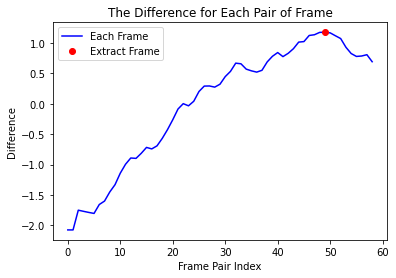

s16_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s16_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[27, 45, 56]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875]
save_key_frame
Extracting idx:27
Extracting idx:45
Extracting idx:56
Done！


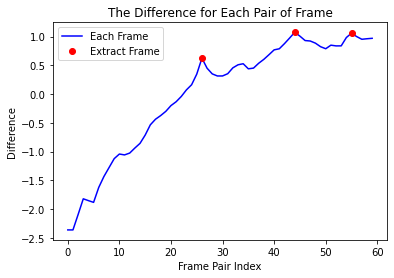

s16_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s16_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[49, 50]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547]
save_key_frame
Extracting idx:49
Extracting idx:50
Done！


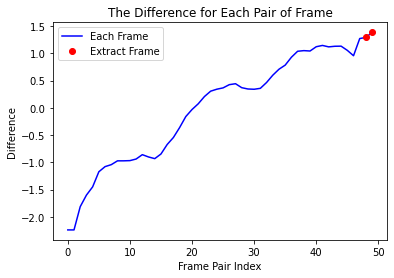

s16_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s16_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[29]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207]
save_key_frame
Extracting idx:29
Done！


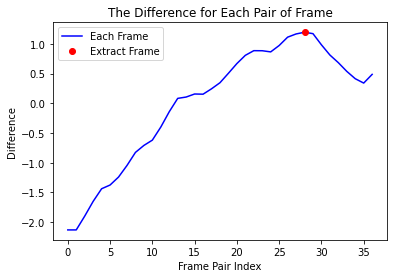

s17_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s17_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[12, 35, 90, 92]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408]
save_key_frame
Extracting idx:12
Extracting idx:35
Extracting idx:90
Extracting idx:92
Done！


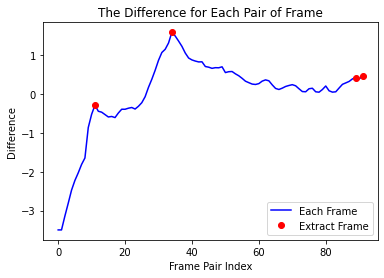

s17_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s17_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
Detect Frame: 100
[0]
pick_idx
Extract the Frame Index:[48, 76]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467]
save_key_frame
Extracting idx:48
Extracting idx:76
Done！


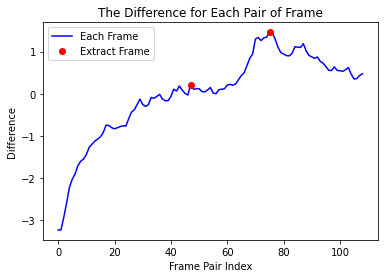

s17_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s17_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
Detect Frame: 100
[0]
pick_idx
Extract the Frame Index:[22, 38, 55, 98]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957]
save_key_frame
Extracting idx:22
Extracting

s17_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s17_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[24, 50]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623]
save_key_frame
Extracting idx:24
Extracting idx:5

s17_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s17_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[33, 64]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773]
save_key_frame
Extracting id

s18_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s18_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[27, 56, 72]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377]
save

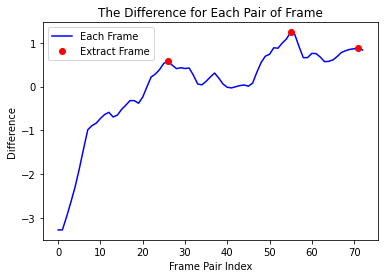

s18_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s18_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[16, 42, 68, 91]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 

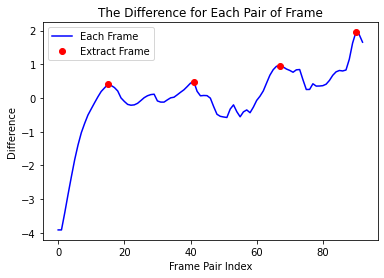

s18_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s18_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[27, 48, 71, 83]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 

s18_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s18_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[12, 57, 68]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

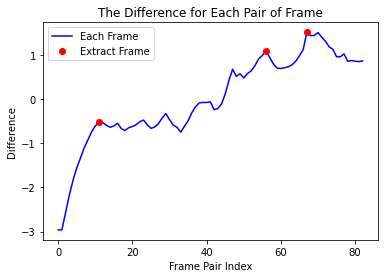

s18_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s18_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[21, 65]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

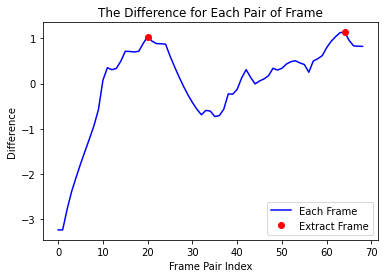

s19_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s19_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[38, 57, 58]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

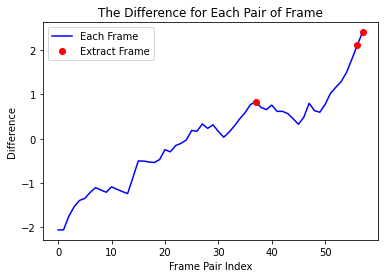

s19_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s19_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[23, 62]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

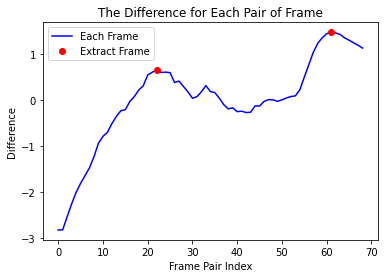

s19_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s19_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[37, 38]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

s19_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s19_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[32, 33]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

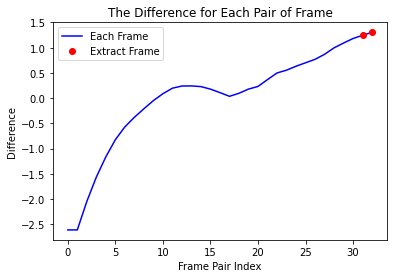

s19_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s19_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[30]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

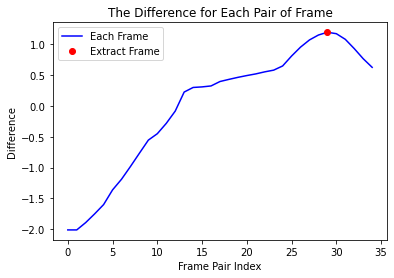

s1_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s1_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[16, 54]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

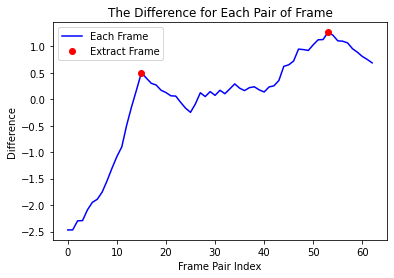

s1_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s1_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[49, 60, 63]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797

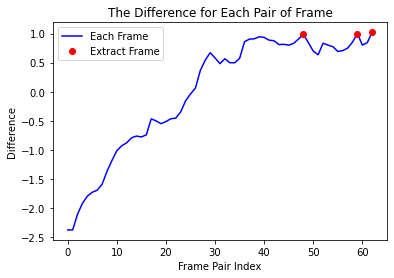

s1_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s1_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[45, 58, 59]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797

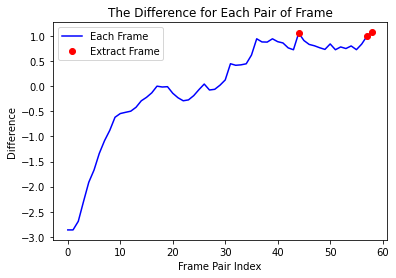

s1_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s1_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[37]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788017272

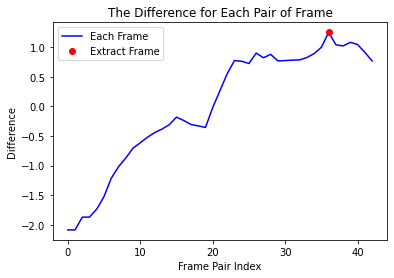

s1_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s1_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[28]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788017272

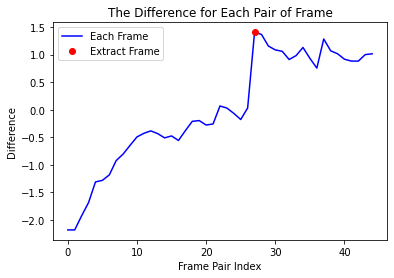

s20_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s20_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[52, 53]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

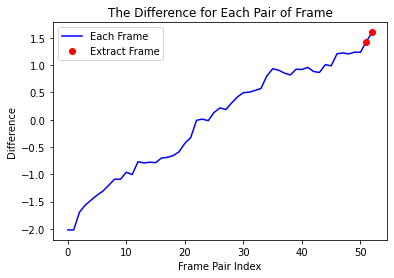

s20_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s20_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[33, 53, 77]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

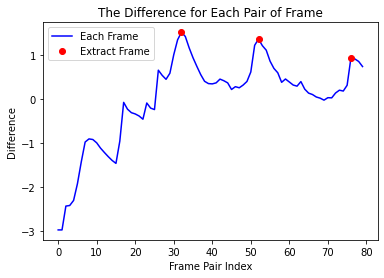

s20_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s20_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[31, 44, 52]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

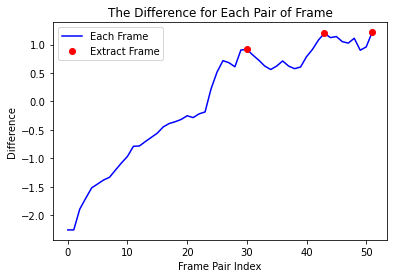

s20_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s20_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[28, 41]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

s20_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s20_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[34]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

s21_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s21_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[29, 71]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

s21_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s21_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[27, 71]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

s21_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s21_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[17]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

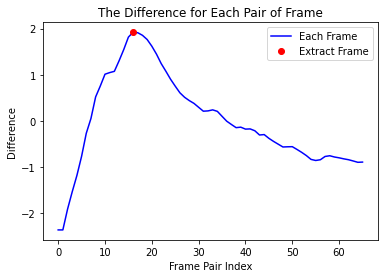

s21_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s21_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[15, 28]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

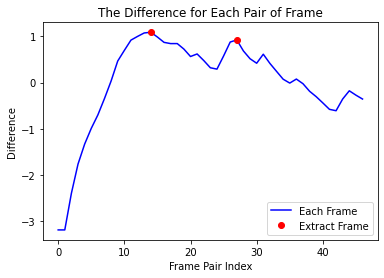

s21_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s21_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[18]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

s22_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s22_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[44]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

s22_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s22_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[37, 62, 63]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

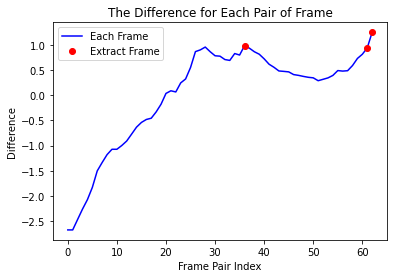

s22_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s22_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[31, 52, 53]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

s22_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s22_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[28]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

s22_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s22_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[28, 40]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

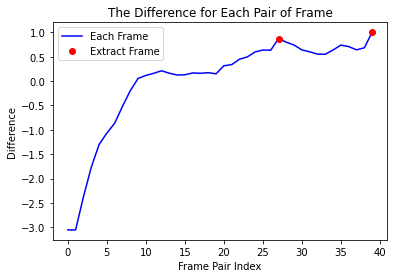

s23_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s23_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[15]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

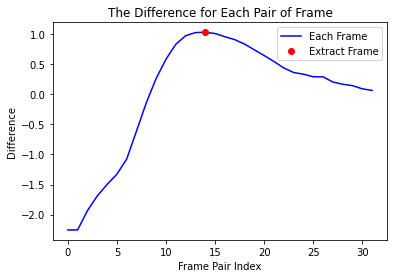

s23_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s23_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[16]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

s24_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s24_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[32]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

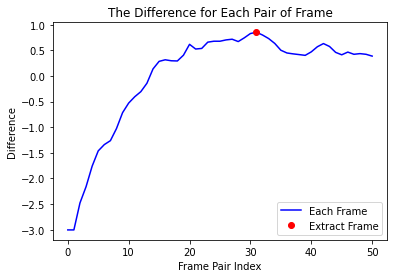

s24_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s24_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[5, 33, 56, 78]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0

s24_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s24_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[14, 69]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

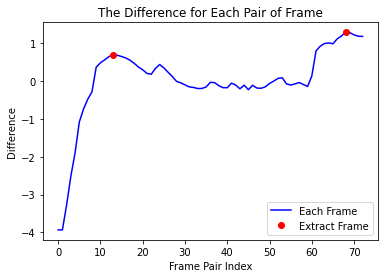

s24_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s24_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[39, 57]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

s24_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s24_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[24, 40, 52]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

s25_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s25_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[35]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

s25_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s25_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[42, 56, 57]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

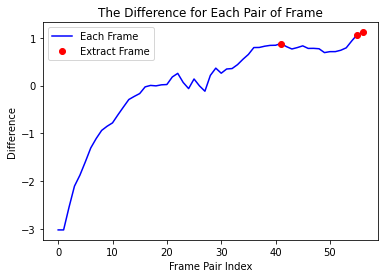

s25_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s25_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[23, 35, 49]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

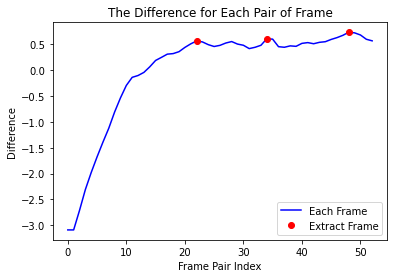

s25_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s25_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[22, 33, 34]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

s25_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s25_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[21, 33]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

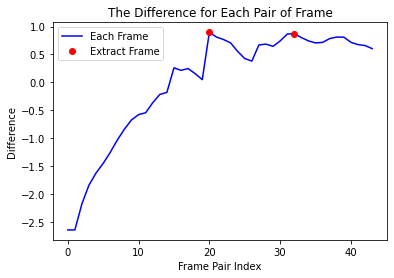

s26_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s26_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[25, 49]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

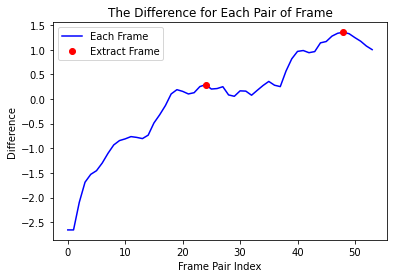

s26_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s26_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[40, 66]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

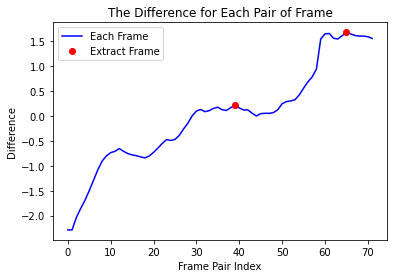

s26_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s26_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[34, 69, 83]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

s26_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s26_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[42]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

s26_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s26_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[21, 38]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

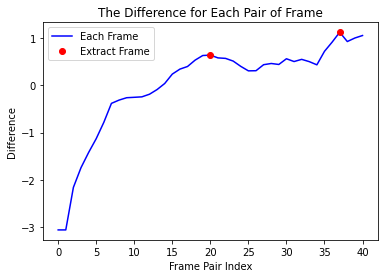

s27_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s27_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[25, 47]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

s27_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s27_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
Detect Frame: 100
[0]
pick_idx
Extract the Frame Index:[11, 40, 91]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646

s27_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s27_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[15, 54]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

s27_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s27_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[14]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

s27_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s27_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[17]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

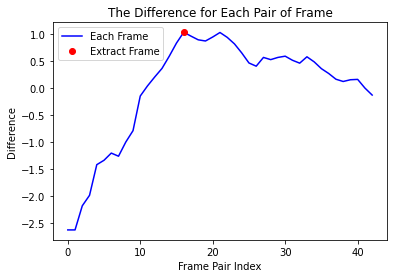

s28_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s28_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[14, 26, 39, 51]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 

s28_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s28_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[30, 64]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

s28_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s28_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[30, 48]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

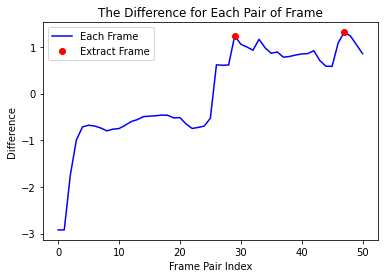

s28_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s28_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[39]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

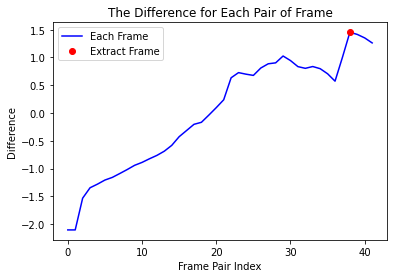

s28_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s28_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[11, 41, 43]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

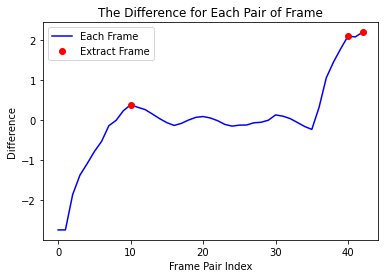

s29_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s29_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[29, 57]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

s29_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s29_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[38, 79]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

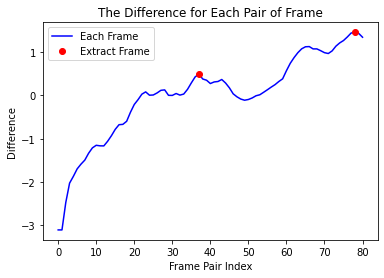

s29_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s29_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[30, 59, 60]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

s29_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s29_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[27, 40]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

s29_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s29_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[22, 36, 42]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

s2_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s2_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[28, 68]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

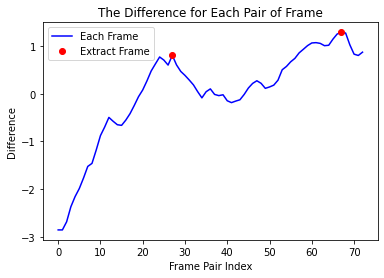

s2_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s2_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[53, 78]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

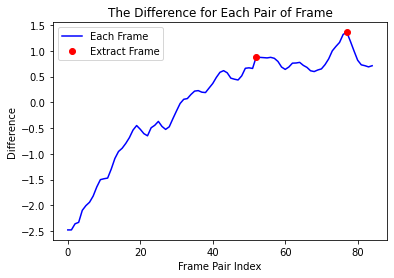

s2_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s2_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[65]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788017272

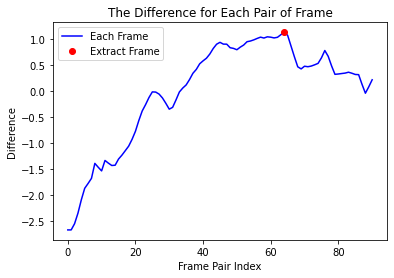

s2_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s2_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[52]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788017272

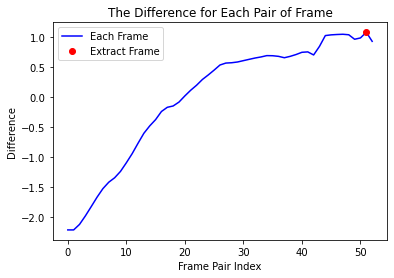

s2_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s2_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 48, 78]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27

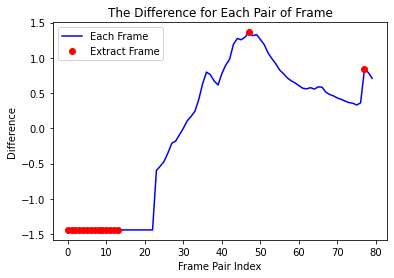

s30_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s30_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[18, 58]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

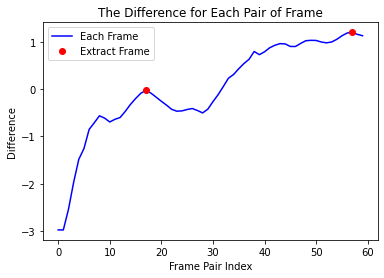

s30_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s30_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[65]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

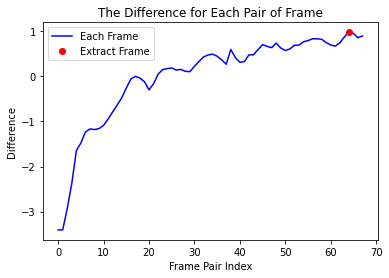

s30_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s30_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[33]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

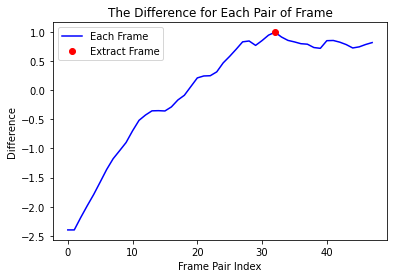

s30_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s30_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[36]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

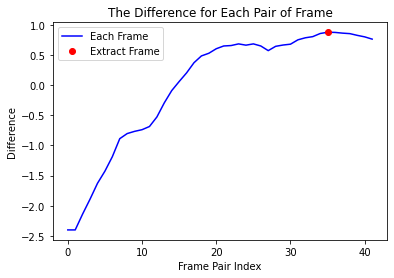

s30_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s30_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[32]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

s31_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s31_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[19, 39]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

s31_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s31_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
Detect Frame: 100
[0]
pick_idx
Extract the Frame Index:[27, 62, 79, 104, 105]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.279164791107177

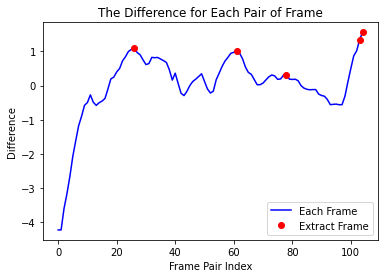

s31_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s31_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
Detect Frame: 100
[0]
pick_idx
Extract the Frame Index:[27, 66, 104, 105]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 

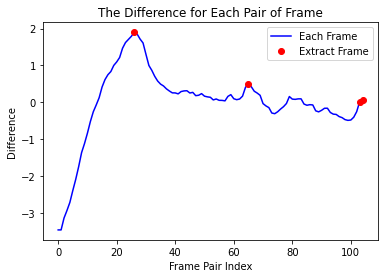

s31_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s31_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[37]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

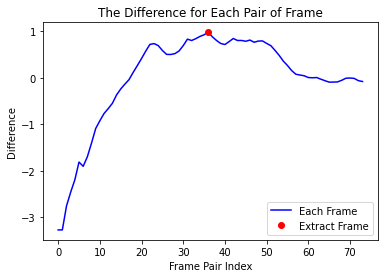

s31_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s31_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[42, 63, 77, 78]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 

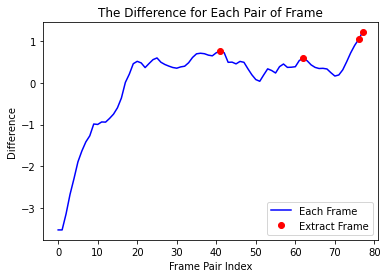

s32_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s32_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[28, 53]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

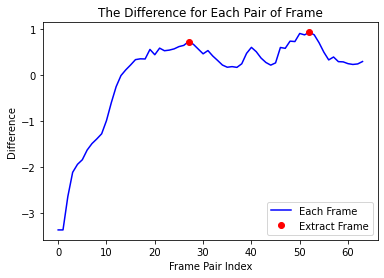

s32_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s32_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[20, 46, 80, 81]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 

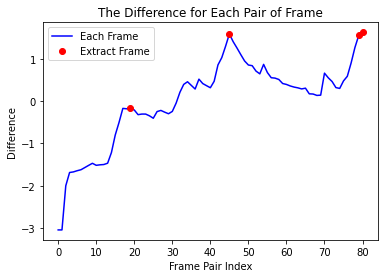

s32_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s32_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
Detect Frame: 100
[0]
pick_idx
Extract the Frame Index:[48, 84]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.26461720

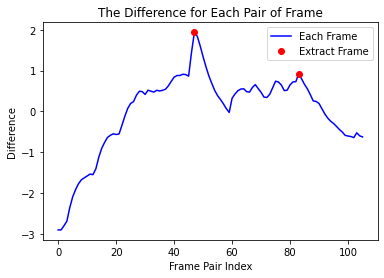

s32_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s32_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[49]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

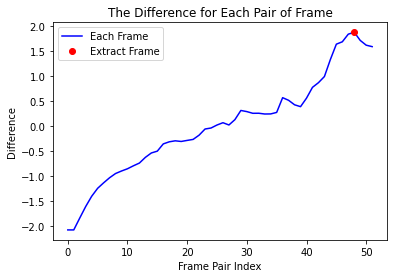

s32_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s32_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[48, 49]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

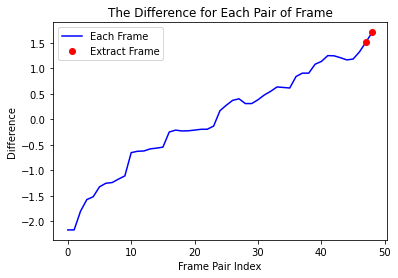

s33_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s33_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[29, 69, 82, 83]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 

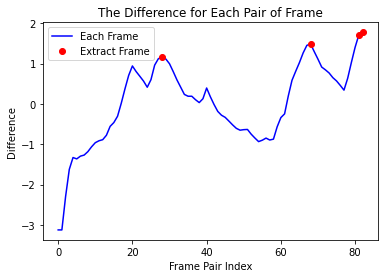

s33_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s33_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[23, 69, 70]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

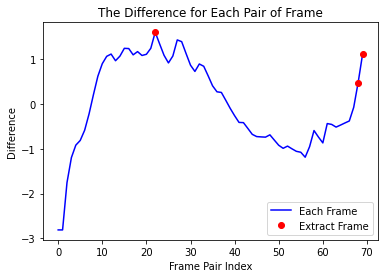

s33_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s33_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[43]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

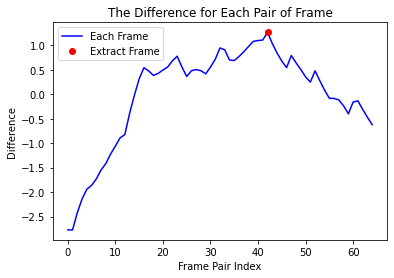

s33_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s33_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[28, 54]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

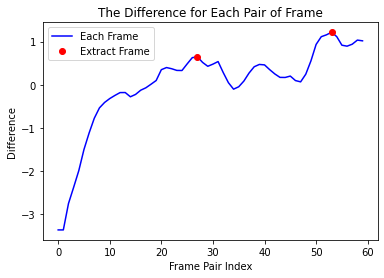

s33_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s33_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[23, 60, 79]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

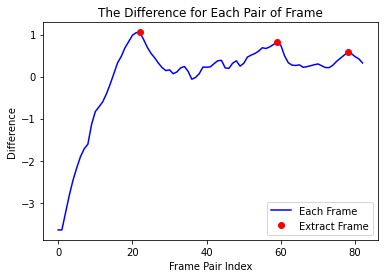

s34_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s34_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[51]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

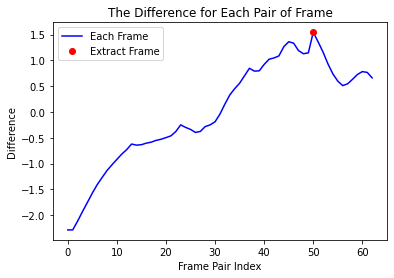

s34_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s34_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[39]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

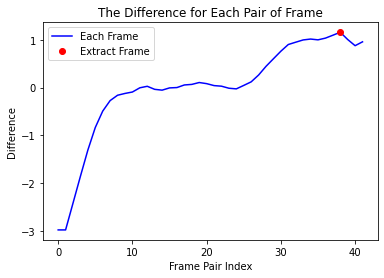

s34_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s34_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[31, 47, 48]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

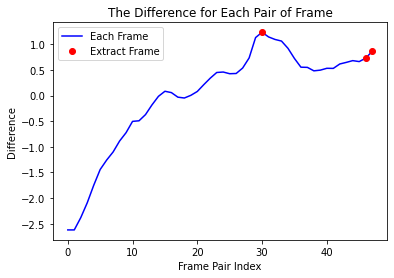

s34_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s34_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[38]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

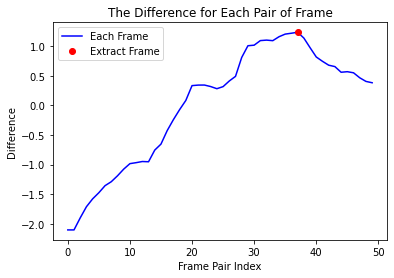

s34_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s34_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[27]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

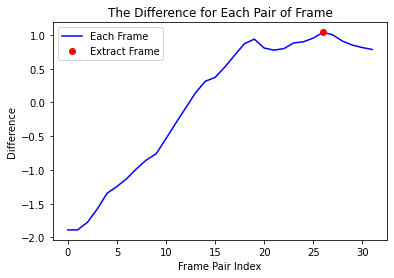

s35_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s35_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[31, 42]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

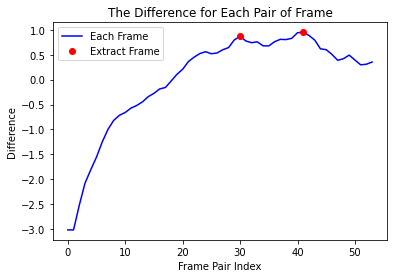

s35_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s35_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[46, 75]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

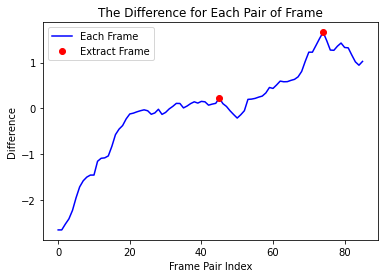

s35_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s35_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[40, 64]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

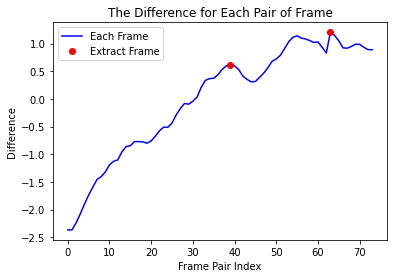

s35_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s35_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[28]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

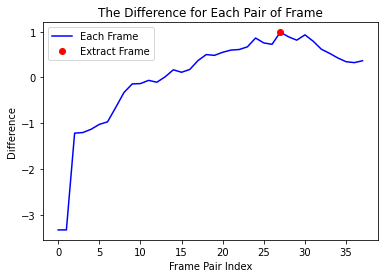

s35_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s35_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[24, 49, 68]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

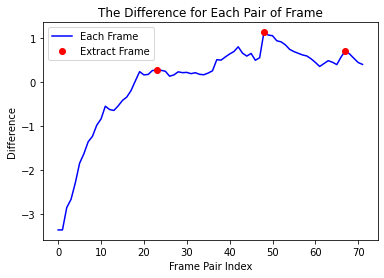

s36_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s36_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[40, 52, 53]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

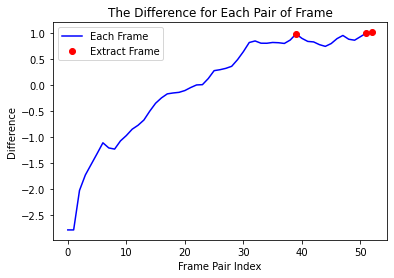

s36_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s36_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[60]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

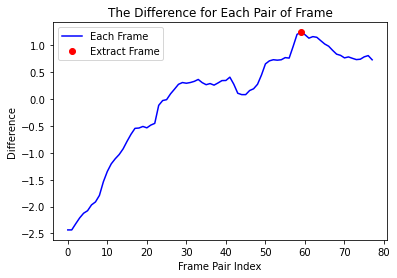

s36_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s36_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[55, 56]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

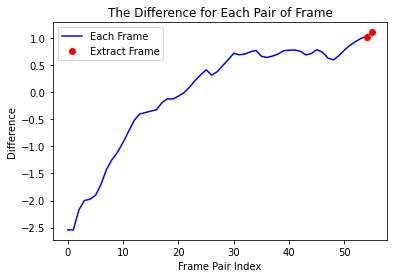

s36_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s36_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[40]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

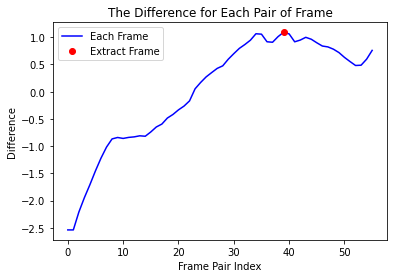

s36_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s36_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[32, 34]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

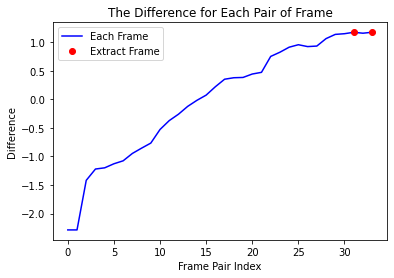

s37_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s37_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[23, 41, 73]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

s37_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s37_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[34, 65]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

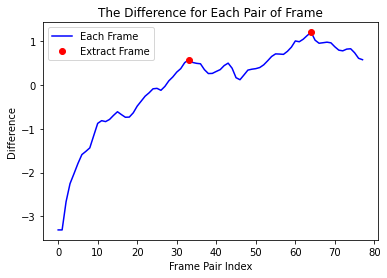

s37_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s37_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[44, 61]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

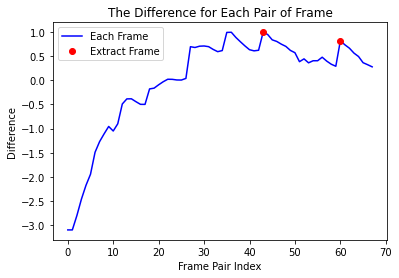

s37_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s37_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[47, 66]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

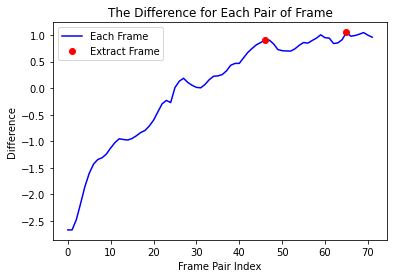

s37_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s37_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[46, 47]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

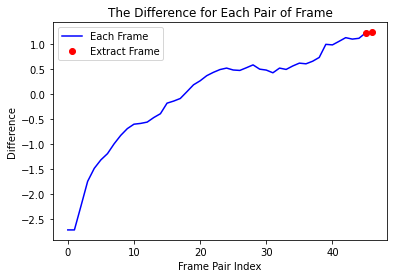

s38_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s38_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[15, 46, 71]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

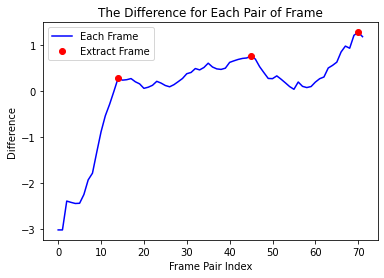

s38_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s38_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[28, 47, 71, 73]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 

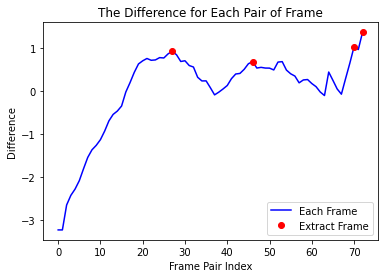

s38_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s38_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[21, 37, 57, 63]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 

s38_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s38_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[49, 50]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

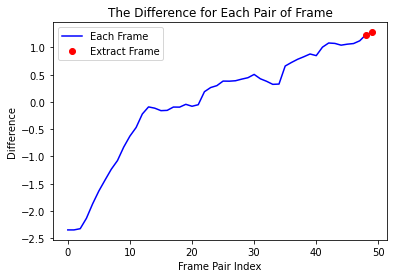

s38_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s38_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[27, 43]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

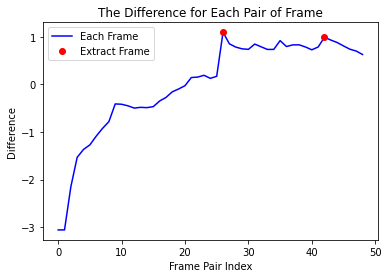

s39_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s39_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[35, 57, 58]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

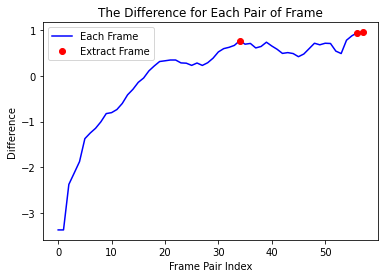

s39_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s39_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[20, 62]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

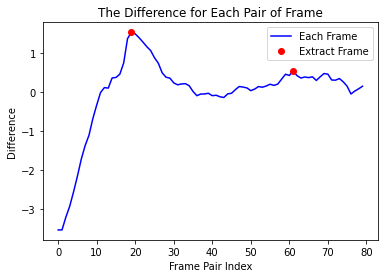

s39_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s39_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[16, 33, 51]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

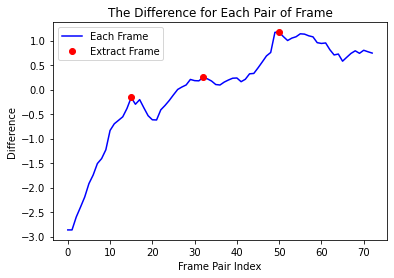

s39_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s39_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[36, 45]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

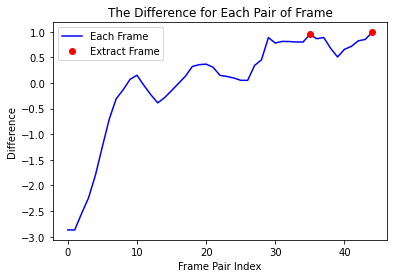

s39_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s39_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[41]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

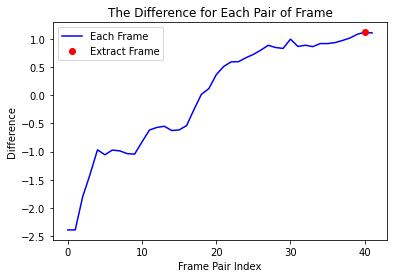

s40_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s40_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[41, 59, 60]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

s40_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s40_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[26, 64, 78]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

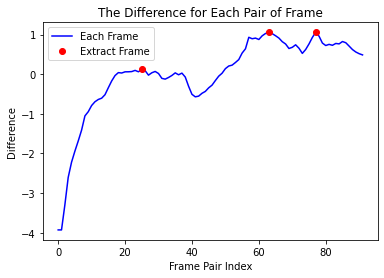

s40_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s40_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[9, 43, 68]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279

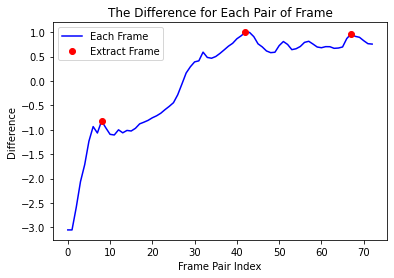

s40_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s40_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[27]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

s40_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s40_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[29]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

s41_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s41_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[42, 52, 63, 86, 87]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.26461720466613

s41_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s41_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
Detect Frame: 100
[0]
pick_idx
Extract the Frame Index:[33, 92]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.26461720

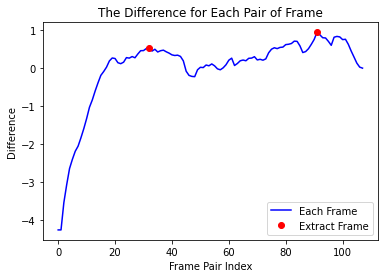

s41_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s41_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[41, 78]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

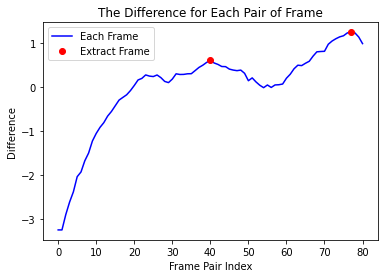

s41_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s41_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[16, 63]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

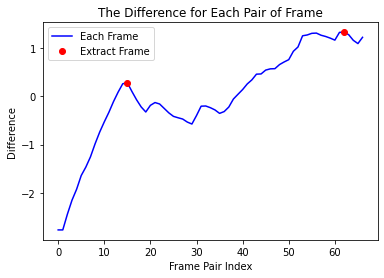

s41_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s41_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[17, 42, 63]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

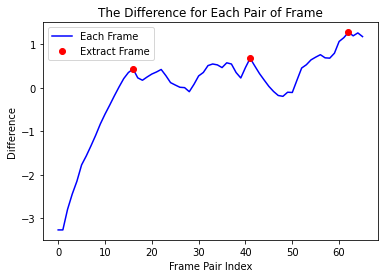

s42_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s42_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[23, 46, 61, 62]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 

s42_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s42_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[24, 55]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

s42_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s42_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[49, 66, 67]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

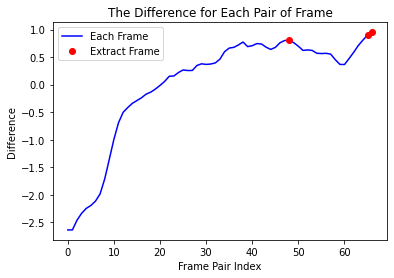

s42_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s42_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[25, 45]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

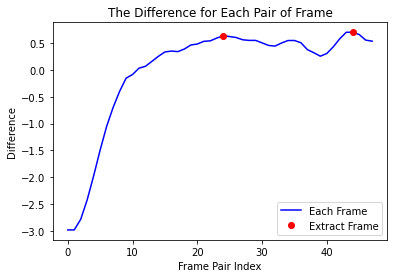

s42_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s42_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[43, 72]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

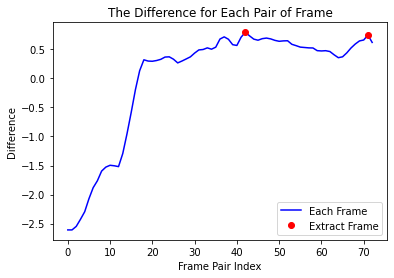

s43_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s43_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[46, 68]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

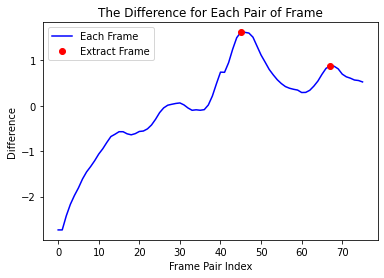

s43_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s43_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[33, 48, 77, 85]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 

s43_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s43_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[27, 50, 66]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

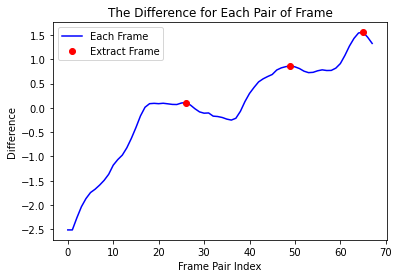

s43_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s43_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[24, 37]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

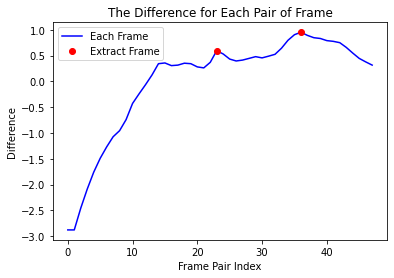

s43_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s43_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[34, 35]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

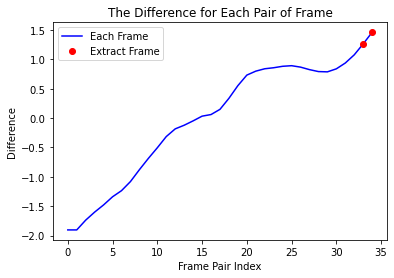

s44_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s44_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[35]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

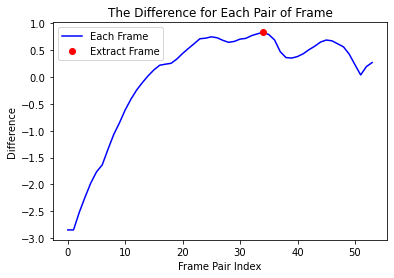

s44_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s44_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[48, 70]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

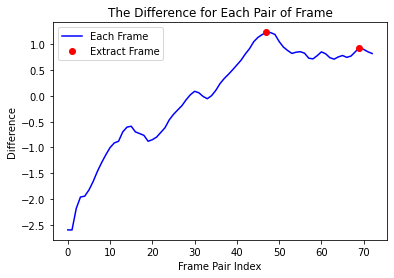

s44_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s44_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[30, 53]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

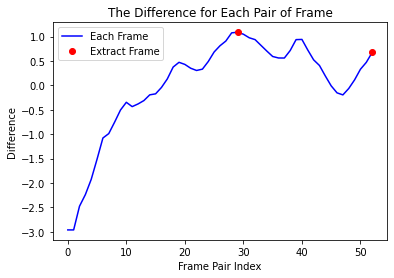

s44_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s44_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[23, 40, 41]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

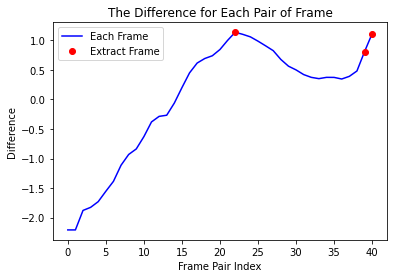

s44_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s44_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[41]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

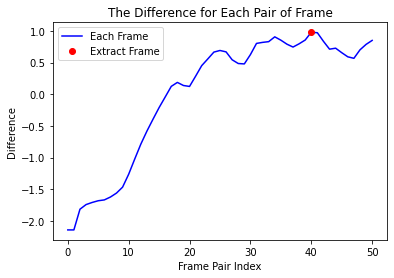

s4_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s4_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[37, 59, 78]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797

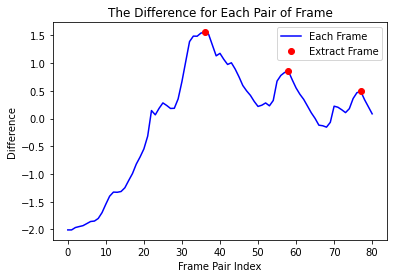

s4_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s4_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[26, 95]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

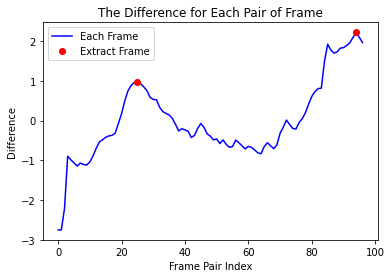

s4_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s4_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[23, 47]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

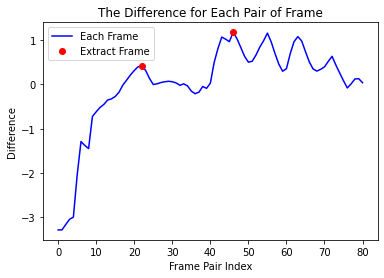

s4_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s4_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[28, 50]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

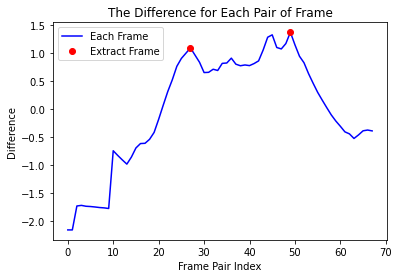

s4_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s4_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[33, 52]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

s5_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s5_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[38]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788017272

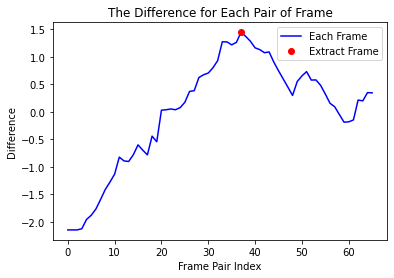

s5_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s5_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[14, 72]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

s5_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s5_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[56]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788017272

s5_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s5_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[23, 53]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

s5_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s5_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[48]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788017272

s6_ha.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s6_ha.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
Detect Frame: 100
Detect Frame: 200
Detect Frame: 300
Detect Frame: 400
Detect Frame: 500
Detect Frame: 600
Detect Frame: 700
Detect Frame: 800
Detect Frame: 900
Detect Frame: 1000
Detect Frame: 1100
Detect Frame: 1200
Detect Frame: 1300
Detect Frame: 1400
Detect Frame: 1500
[0]
pick_idx
Extract the Frame Index:[26, 60, 82, 114, 159, 174, 203, 217, 243, 259, 302, 343, 368, 389, 412, 450, 468, 479, 544, 577, 606, 673, 689, 705, 730, 768, 800, 849, 865, 895, 963, 988, 1043, 1063, 1077, 1108, 1134, 1185, 1215, 1234, 1246, 1282, 1364, 1382, 1425, 1475, 1511, 1524, 1581]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 

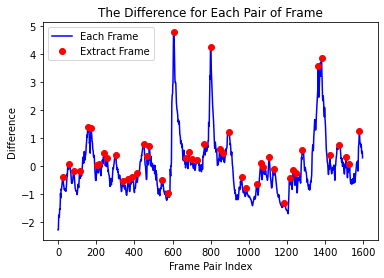

s7_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s7_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[31, 49, 67, 68]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.

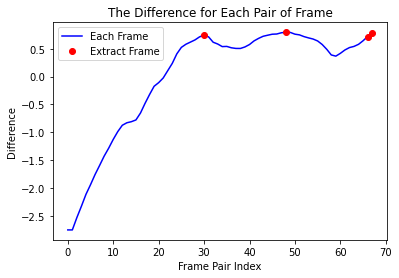

s7_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s7_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[39, 59, 89]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797

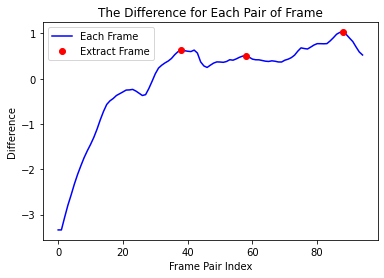

s7_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s7_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[49]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788017272

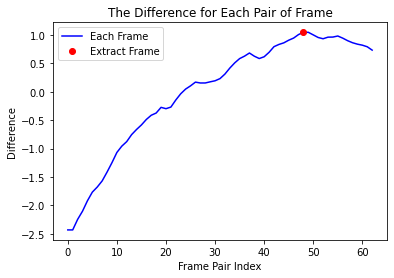

s7_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s7_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[67, 68]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

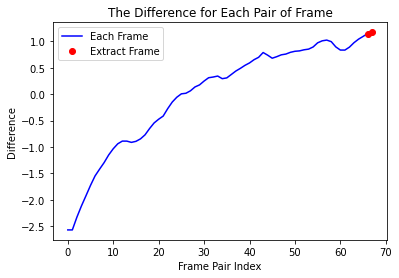

s7_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s7_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[36, 55]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

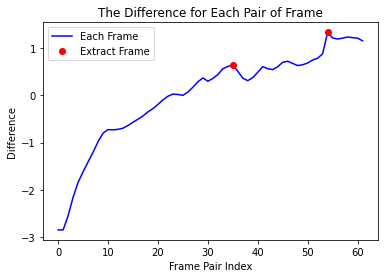

s8_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s8_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[14, 39, 56, 70]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.

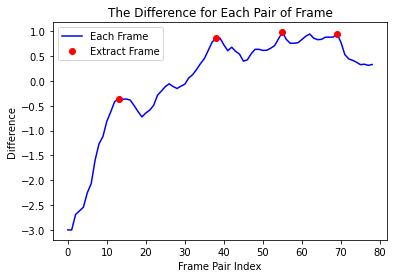

s8_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s8_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[65]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788017272

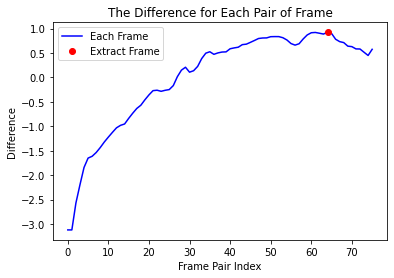

s8_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s8_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[46]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788017272

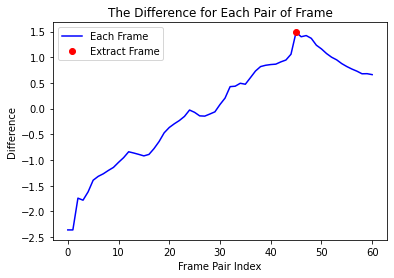

s8_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s8_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[47]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788017272

s8_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s8_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[26, 48]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

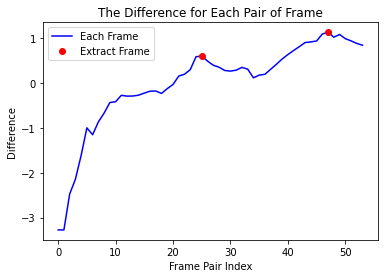

s9_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s9_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[51, 63]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

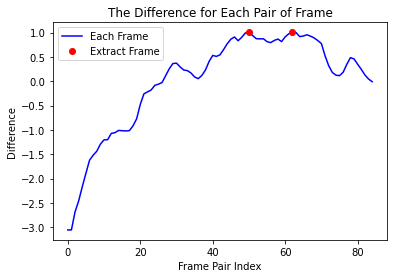

s9_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s9_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[19, 31, 83]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797

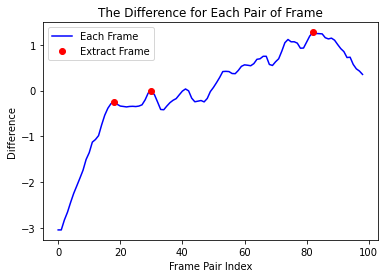

s9_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s9_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[55, 56]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

s9_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s9_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[34, 47]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27978801

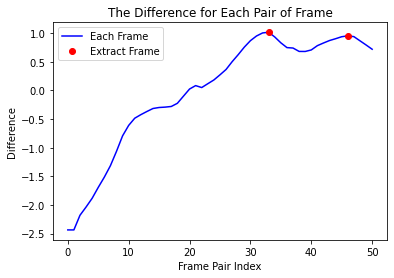

s9_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s9_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[33]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788017272

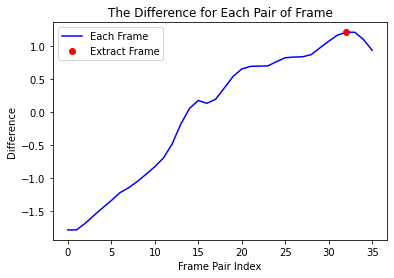

s_3_ha_1.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s_3_ha_1.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[21, 40, 70]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.27

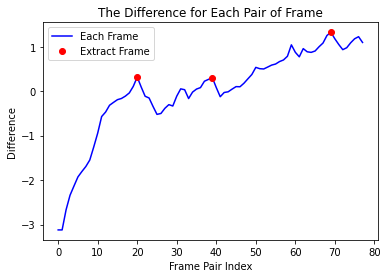

s_3_ha_2.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s_3_ha_2.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[33, 45]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

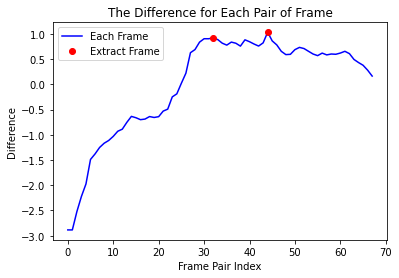

s_3_ha_3.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s_3_ha_3.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
Detect Frame: 100
[0]
pick_idx
Extract the Frame Index:[33, 57, 80, 107, 108]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.279164791107177

s_3_ha_4.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s_3_ha_4.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[27, 46]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.279788

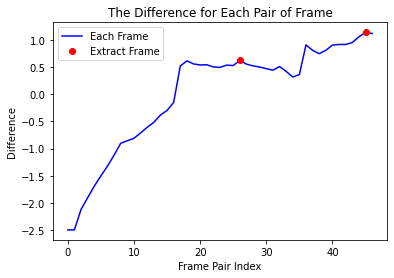

s_3_ha_5.avi
The source file directory is D:/enterface_allVideo/ha
The source file path is D:/enterface_allVideo/ha\s_3_ha_5.avi
The destination file path is D:/KeyFrames_eNTERFACE/ha1
load_diff_between_frm
[0]
pick_idx
Extract the Frame Index:[34]
[0.2604379653930664, 0.21824240684509277, 0.26862668991088867, 0.22869634628295898, 0.17028498649597168, 0.23332500457763672, 0.329667329788208, 0.23915743827819824, 0.2776925563812256, 0.23170995712280273, 0.319044828414917, 0.2962214946746826, 0.2881159782409668, 0.2394113540649414, 0.2987809181213379, 0.24834537506103516, 0.23810553550720215, 0.23590493202209473, 0.22425532341003418, 0.19693446159362793, 0.19023537635803223, 0.23389840126037598, 0.2297816276550293, 0.12064003944396973, 0.13781189918518066, 0.17831158638000488, 0.22870755195617676, 0.209930419921875, 0.1614208221435547, 0.14535069465637207, 0.3481018543243408, 0.3827788829803467, 0.36182713508605957, 0.2154853343963623, 0.27916479110717773, 0.2646172046661377, 0.2797880172

In [22]:
if __name__ == '__main__':
    sa = []
    for root, dirs, files in os.walk('D:/enterface_allVideo/ha' ):
        for file in files:
            print(file)

            source_path = os.path.join(root, file)
            #+ file.strip('.avi').strip('.mp4') +
            dir_path = 'D:/KeyFrames_eNTERFACE/ha1' 

            print("The source file directory is", root)
            print("The source file path is", source_path)
            print("The destination file path is", dir_path)

            if not os.path.exists(dir_path):
                os.mkdir(dir_path)

            kfg = KeyFrameGetter(source_path, dir_path,  20)
            a = time.time()
            kfg.load_diff_between_frm(alpha=0.07)  # GetTake model parameters
            b = time.time()
            sa.append(b - a)
            print(sa)
            kfg.save_key_frame()  # Save the corresponding picture in the index list

            # This sentence is to print the difference information of each picture

            kfg.plot_diff_time()